In [1]:
!pip install casadi
from IPython.display import clear_output
import os

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

In [2]:
g = 9.81 #重力加速度
M = 1 #台車の質量
m = 0.2 #振子の質量
l = 1 #振子の長さ

nu = 1 #制御変数の次元
nx = 4 #状態変数の次元
nw = 4 #プロセスノイズの次元
no = 2 #観測状態の次元

# コスト関数の重み
Q_MPC = casadi.diag([2.5,10,0.01,0.01])
Q_f_MPC = casadi.diag([2.5,10,0.01,0.01])
R_MPC = casadi.diag([0.1])

Q_MHE = casadi.diag([10,10])
Q_i_MHE = casadi.diag([0.1,0.1,0.1,0.1])
R_MHE = casadi.diag([1,1,1,1])

# 予測ホライズン等
T = 1
N = 20
dt = T/N

# 制約条件
x_lb = [-np.inf,-np.inf,-np.inf,-np.inf]
x_ub = [np.inf,np.inf,np.inf,np.inf]
u_lb = [-15]
u_ub = [15]
w_lb = [-np.inf,-np.inf,-np.inf,-np.inf]
w_ub = [np.inf,np.inf,np.inf,np.inf]

total_MPC = nx*(N+1) + nu*N
total_MHE = nx*(N+1) + nw*N + nu*N + no*N + nx

In [3]:
def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)
    noises = casadi.SX.sym("noises",nw)

    x = states[0]
    theta = states[1]
    x_dot = states[2]
    theta_dot = states[3]
    F = ctrls[0]

    sin = casadi.sin(theta)
    cos = casadi.cos(theta)
    det = M+m*sin**2

    x_ddot = (-m*l*sin*theta_dot**2+m*g*sin*cos+F)/det
    theta_ddot = (-m*l*sin*cos*theta_dot**2+(M+m)*g*sin+F*cos)/(l*det)

    states_dot = casadi.vertcat(x_dot,theta_dot,x_ddot,theta_ddot) + noises

    f = casadi.Function("f",[states,ctrls,noises],[states_dot],['x','u',"w"],['x_dot'])
    return f

def make_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)
    noises = casadi.SX.sym("noises",nw)

    f = make_f()

    k1 = f(x=states,u=ctrls,w=noises)["x_dot"]
    k2 = f(x=states+dt*k1/2,u=ctrls,w=noises)["x_dot"]
    k3 = f(x=states+dt*k2/2,u=ctrls,w=noises)["x_dot"]
    k4 = f(x=states+dt*k3,u=ctrls,w=noises)["x_dot"]

    states_next = states + dt*(k1+2*k2+2*k3+k4)/6

    RK4 = casadi.Function("RK4",[states,ctrls,noises],[states_next],["x","u","w"],["x_next"])
    return RK4

def make_g():
    states = casadi.SX.sym("states",nx)

    C = casadi.DM([
        [1,0,0,0],
        [0,1,0,0]
    ])

    observes = C @ states

    g = casadi.Function("g",[states],[observes],['x'],['y'])
    return g

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)
    noises = casadi.SX.sym("noises",nw)

    f = make_f()
    ode = f(x=states, u=ctrls,w=noises)["x_dot"]
    params = casadi.vertcat(ctrls,noises)
    dae = {"x":states,"p":params,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_MPC_stage_cost(x,u):
    cost = (casadi.dot(Q_MPC@x,x) + casadi.dot(R_MPC@u,u)) / 2
    return cost

def compute_MPC_final_cost(x):
    cost = casadi.dot(Q_f_MPC@x,x) / 2
    return cost

def compute_MHE_stage_cost(y,y_hat,w):
    y_diff = y - y_hat
    cost = casadi.dot(Q_MHE@y_diff,y_diff) / 2 + casadi.dot(R_MHE@w,w) / 2
    return cost

def compute_MHE_initial_cost(x,x_hat):
    x_diff = x - x_hat
    cost = casadi.dot(Q_i_MHE@x_diff,x_diff) / 2
    return cost

In [4]:
def make_MPC_nlp():
    RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(N)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(N+1)]
    G = []

    J = 0

    for k in range(N):
        J += compute_MPC_stage_cost(X[k],U[k]) * dt
        eq = X[k+1] - RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_MPC_final_cost(X[-1])

    option = {'print_time':False,'ipopt':{'max_iter':20,'print_level':0}}
    nlp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S_MPC","ipopt",nlp,option)
    return S

def make_MHE_nlp():
    RK4 = make_RK4()
    g = make_g()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(N)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(N+1)]
    Y = [casadi.SX.sym(f"y_{i}",no) for i in range(N)]
    W = [casadi.SX.sym(f"w_{i}",nw) for i in range(N)]
    x_hat = casadi.SX.sym("x_hat",nx)
    G = []

    J = 0
    J += compute_MHE_initial_cost(X[0],x_hat)
    for k in range(N):
        y_hat = g(X[k])
        J += compute_MHE_stage_cost(Y[k],y_hat,W[k]) * dt
        eq = X[k+1] - RK4(x=X[k],u=U[k],w=W[k])["x_next"]
        G.append(eq)

    option = {'print_time':False,'ipopt':{'max_iter':30,'print_level':0}}
    nlp = {"x":casadi.vertcat(*X,*W,*U,*Y,x_hat),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S_MHE","ipopt",nlp,option)
    return S

In [5]:
def compute_optimal_control(S,x_s,x0):
    x_s = x_s.full().ravel().tolist()
    
    lbx = x_s + x_lb*N + u_lb*N
    ubx = x_s + x_ub*N + u_ub*N
    lbg = [0]*nx*N
    ubg = [0]*nx*N

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(N+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

def compute_optimal_estimation(S,us,ys,x0,x_hat):
    lbx = x_lb*(N+1) + w_lb*N + us + ys + x_hat
    ubx = x_ub*(N+1) + w_ub*N + us + ys + x_hat
    lbg = [0]*nx*N
    ubg = [0]*nx*N

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    # offset = nx*(N+1)
    x0 = res["x"]
    return x0

In [6]:
S_MPC = make_MPC_nlp()
S_MHE = make_MHE_nlp()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



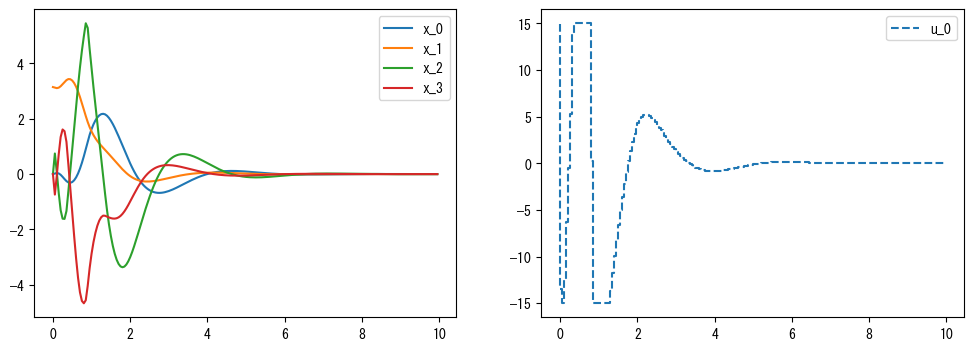

In [7]:
t_span = [0,10]
t_eval = np.arange(*t_span,dt)

x_init = casadi.DM([0,np.pi,0,0]) # 初期値
x0 = casadi.DM.zeros(total_MPC)

I = make_integrator()

X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt,x0 = compute_optimal_control(S_MPC,x_current,x0)
    p_current = casadi.DM([u_opt,*np.zeros(nw)])
    x_current = I(x0=x_current,p=p_current)["xf"]
    X.append(x_current)
    U.append(u_opt)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()

plt.savefig("images/chap8_cart_pole_MPC.png")
plt.show()

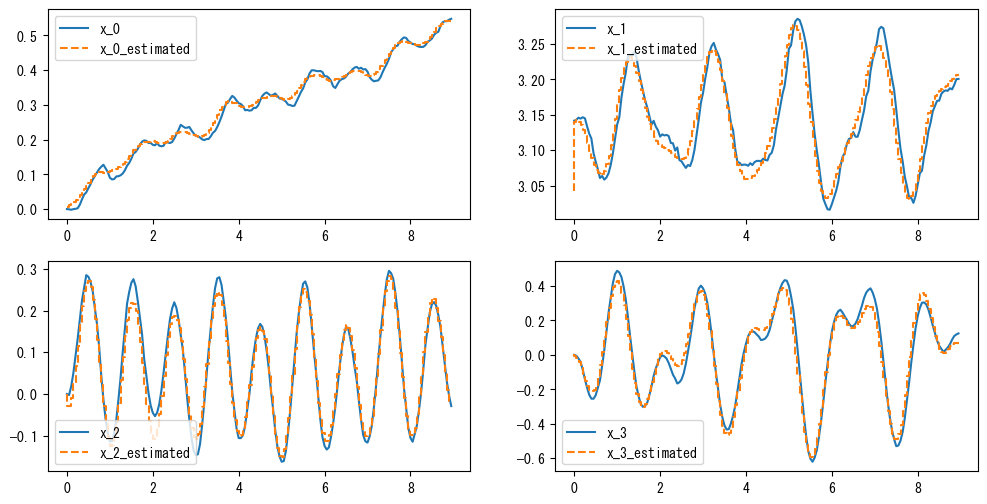

In [9]:
t_span = [0,10]
t_eval = np.arange(*t_span,dt)

I = make_integrator()
h = make_g()

x_init = casadi.DM([0,np.pi,0,0]) # 初期値
y_init = h(x_init)
x0 = casadi.DM.zeros(total_MHE)
x_hat = casadi.DM([0,0,0,0])

X = [x_init]
X_est = []
Y = [y_init]
U = []
x_current = x_init
for t in t_eval:
    if len(Y) > N:
        ys = casadi.vertcat(*Y[-N:]).full().ravel().tolist()
        us = casadi.vertcat(*U[-N:]).full().ravel().tolist()
        x_hat_list = x_hat.full().ravel().tolist()
        x0 = compute_optimal_estimation(S_MHE,us,ys,x0,x_hat_list)
        x_est = x0[:nx]
        X_est.append(x_est)
        x_hat = x_est
    u_current = casadi.DM([np.sin(2*np.pi*t)])
    w_current = np.random.normal(size=(nw,),scale=0.1)
    p_current = casadi.DM([u_current,*w_current])
    x_current = I(x0=x_current,p=p_current)["xf"]
    y_current = h(x_current)
    X.append(x_current)
    Y.append(y_current)
    U.append(u_current)
    # U.append(u_opt)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
# X_est.pop()
X_est = np.array(X_est).reshape(-1,nx)

plt.figure(figsize=(12,6))

for i in range(nx):
    plt.subplot(2,2,i+1)
    plt.plot(t_eval[:-N],X[:-N,i],label=f"x_{i}")
    plt.step(t_eval[:-N],X_est[:,i],linestyle="--",label=f"x_{i}_estimated")
    plt.legend()

plt.savefig("images/chap8_cart_pole_MHE.png")
plt.show()

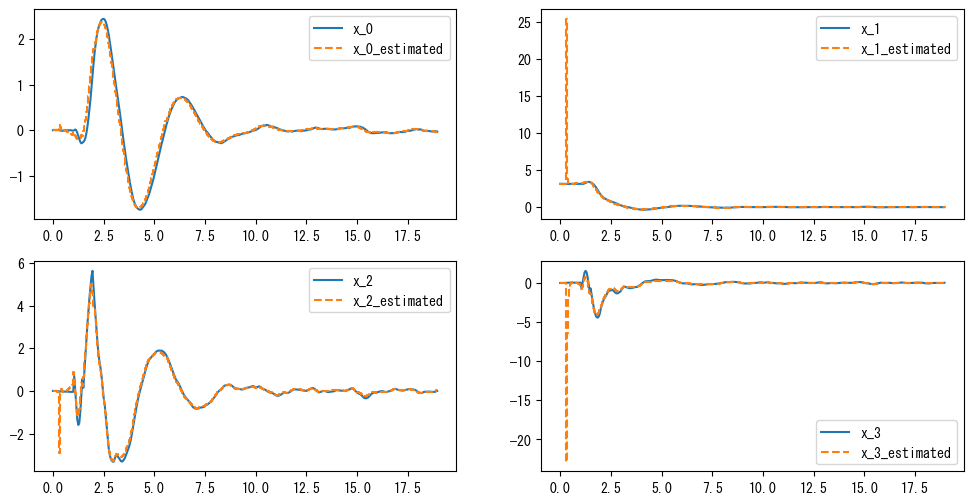

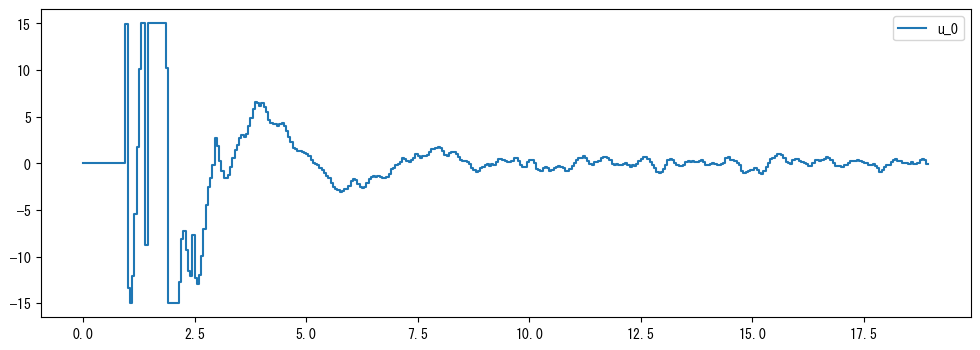

In [11]:
t_span = [0,20]
t_eval = np.arange(*t_span,dt)

I = make_integrator()
h = make_g()

x_init = casadi.DM([0,np.pi,0,0]) # 初期値
y_init = h(x_init)
x0_MPC = casadi.DM.zeros(total_MPC)
x0_MHE = casadi.DM.zeros(total_MHE)
x_hat = casadi.DM([0,0,0,0])

X = [x_init]
X_est = []
Y = [y_init]
U = []
x_current = x_init
x_current_est = x_hat
for t in t_eval:
    if len(Y) > N:
        ys = casadi.vertcat(*Y[-N:]).full().ravel().tolist()
        us = casadi.vertcat(*U[-N:]).full().ravel().tolist()
        x_hat_list = x_hat.full().ravel().tolist()
        x0 = compute_optimal_estimation(S_MHE,us,ys,x0_MHE,x_hat_list)
        x_est = x0[:nx]
        X_est.append(x_est)
        x_hat = x_est
        x_current_est = x0[nx*N:nx*(N+1)]
    u_opt,x0_MPC = compute_optimal_control(S_MPC,x_current_est,x0_MPC)
    w_current = np.random.normal(size=(nw,),scale=0.1)
    p_current = casadi.DM([u_opt,*w_current])
    x_current = I(x0=x_current,p=p_current)["xf"]
    y_current = h(x_current)
    X.append(x_current)
    Y.append(y_current)
    U.append(u_opt)
    # U.append(u_opt)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
# X_est.pop()
X_est = np.array(X_est).reshape(-1,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,6))

for i in range(nx):
    plt.subplot(2,2,i+1)
    plt.plot(t_eval[:-N],X[:-N,i],label=f"x_{i}")
    plt.step(t_eval[:-N],X_est[:,i],linestyle="--",label=f"x_{i}_estimated")
    plt.legend()

plt.savefig("images/chap8_cart_pole_MPCxMHE_state.png")
plt.show()

plt.figure(figsize=(12,4))

for i in range(nu):
    plt.subplot(nu,1,i+1)
    plt.step(t_eval[:-N],U[:-N,i],label=f"u_{i}")
    plt.legend()

plt.savefig("images/chap8_cart_pole_MPCxMHE_ctrl.png")
plt.show()

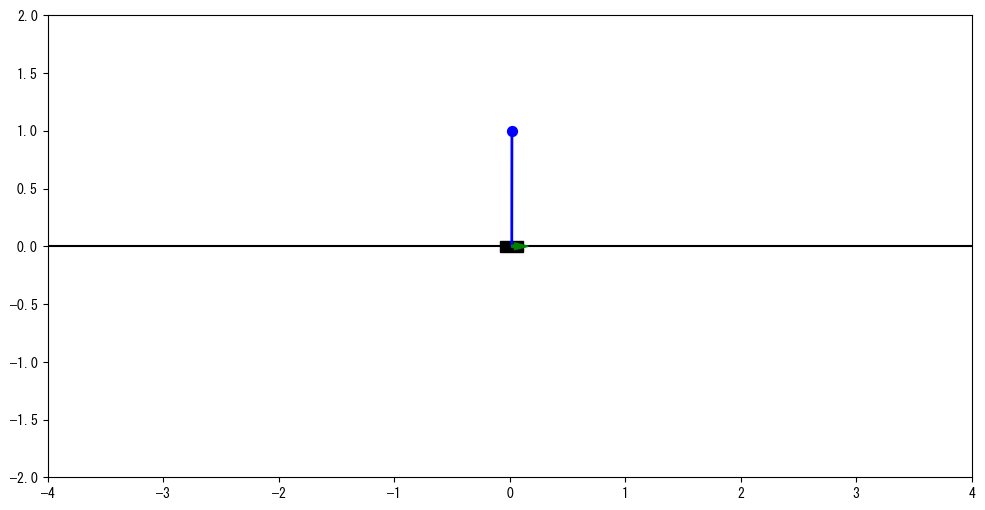

In [12]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
frames = np.arange(0,t_eval.size)
fps = 1 / dt

def update_figure(i):
    x_lim_min = -4
    x_lim_max = 4
    y_lim_min = -2
    y_lim_max = 2
    u_scale = 15

    ax.cla()
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.set_ylim(y_lim_min, y_lim_max)
    ax.set_aspect("equal")

    x,theta,_,_ = X[i]
    u, = U[i]

    points = np.array([
        [x,x-l*np.sin(theta)],
        [0,l*np.cos(theta)]
    ])

    ax.hlines(0,x_lim_min,x_lim_max,colors="black")
    ax.scatter(*points,color="blue", s=50)
    ax.plot(*points, color='blue', lw=2)
    ax.arrow(x,0,u/u_scale,0,width=0.02,head_width=0.06,head_length=0.12,length_includes_head=False,color="green",zorder=3)

    w = 0.2
    h = 0.1
    rect = patches.Rectangle(xy=(x-w/2,-h/2), width=w, height=h,color="black")
    ax.add_patch(rect)

ani = FuncAnimation(fig, update_figure, frames=frames)
ani.save("images/chap8_cart_pole.gif",writer="pillow",fps=fps)

In [19]:
# import os
# import shutil
# import glob
# import natsort
# import cv2
# shutil.rmtree("./tmp",ignore_errors=True)
# os.mkdir("./tmp")
# for i in np.linspace(0,149,12):
#     i = int(i)
#     update_figure(i)
#     fig.savefig(f"./tmp/_frame_{i}.png")
# paths = glob.glob("./tmp/*.png")
# paths = natsort.natsorted(paths)
# paths = [cv2.imread(path) for path in paths]
# paths = np.stack(paths,axis=0)
# paths = paths.reshape(4,3,600,1200,3)
# paths = np.concatenate(paths,axis=1)
# paths = np.concatenate(paths,axis=1)
# cv2.imwrite("images/chap8_cart_pole_anim.png",paths)
# shutil.rmtree("./tmp",ignore_errors=True)